In [2]:
import random
import os
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from skimage import feature
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/10701 Project/Places365
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1LctJnKZFNvssVRAeqcgI-q6k_UArdIHZ/Places365
categories_places365.txt	 train_256_places365standard.tar
data_256_standard		 train_hog_images_20k_to_40k.npy
filelist_places365-standard.tar  train_hog_images.npy
places365_test.txt		 train_hog_labels_20k_to_40k.npy
places365_train_standard.txt	 train_hog_labels.npy
test_hog_images.npy		 val_256
test_hog_labels.npy		 val_256.tar


In [ ]:
with open('places365_train_standard.txt') as f:
    lines = f.readlines()

sample_n = len(lines)
random.shuffle(lines)

print("Loaded", sample_n, "samples")

train_n = sample_n // 10 * 7
val_n = sample_n // 10 * 2
test_n = sample_n - train_n - val_n

train_entries = lines[ : train_n]
val_entries = lines[train_n : train_n+val_n]
test_entries = lines[train_n+val_n:]


Loaded 149168 samples


In [ ]:
# This function splits every entry and returns (paths, labels)
# /a/airfield/00000001.jpg 0
def split_entries(entries):
  paths = []
  labels = []
  
  for entry in entries:
    parts = entry.split(' ')
    paths.append(parts[0])
    labels.append(parts[1])
  
  return (paths, labels)

In [ ]:
(train_paths, train_labels) = split_entries(train_entries)
(val_paths, val_labels) = split_entries(val_entries)
(test_paths, test_labels) = split_entries(test_entries)

Images = []
Labels = []

In [ ]:
hog_i = 0

In [ ]:

def hog(paths, labels):
  global hog_i
  N = len(paths)

  while hog_i < N:
    # prepare file path and label
    path = paths[hog_i]
    # print('i=', i, 'path', path)
    image_path = 'data_256_standard' + path
    label = int(labels[hog_i][:-1])

    # read image
    image = np.asarray(PIL.Image.open(image_path))
    image = cv2.resize(image, (128, 256))

    # hog
    hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    
    # update loop variable
    Images.append(hog_desc)
    Labels.append(label)
    hog_i += 1
    


In [ ]:
hog(train_paths[20000:40000], train_labels[20000:40000])
np.save('train_hog_images_20k_to_40k.npy', Images)
np.save('train_hog_labels_20k_to_40k.npy', Labels)
# print(Images)
# print(Labels)

#Save hog representation#

#SVM#

In [ ]:
Images, Labels = [], []

In [ ]:
def train_initialize(trainImages, trainLabels):
  N = len(trainImages)

  for i in range(N):
    hog_feature = trainImages[i]
    label = trainLabels[i]

    Images.append(hog_feature)
    Labels.append(label)

In [ ]:
final_train_images = np.load('train_hog_images.npy')
final_train_labels = np.load('train_hog_labels.npy')

train_initialize(final_train_images, final_train_labels)


In [ ]:
print('Training on train images...')
svm_model = LinearSVC(random_state=42, tol=1e-3, verbose=1, C=0.1)
svm_model.fit(Images[:10000], Labels[:10000])
print('Finish trining SVM')

Training on train images...
[LibLinear]Finish trining SVM


In [ ]:
def train_accuracy(images, labels):
  N = len(images)
  correctN = 0

  for i in range(N):
    hog_feature = images[i]
    label = labels[i]

    pred = svm_model.predict(hog_feature.reshape(1, -1))[0]

    if pred == label:
      correctN += 1

  return correctN /N

In [ ]:
accuracy = train_accuracy(final_train_images[:10000], final_train_labels[:10000])
print("n = 1000 accuracy", accuracy)

n = 1000 accuracy 1.0


#Test#

In [ ]:
final_test_images = np.load('test_hog_images.npy')
final_test_labels = np.load('test_hog_labels.npy')

In [ ]:
def test_accuracy(images, labels):
  N = len(images)
  correctN = 0

  for i in range(N):
    hog_feature = final_test_images[i]
    label = labels[i]

    pred = svm_model.predict(hog_feature.reshape(1, -1))[0]

    if pred == label:
      correctN += 1

  return correctN /N

In [ ]:
accuracy = test_accuracy(final_test_images, final_test_labels)
print("n = 10000 accuracy", accuracy)

n = 10000 accuracy 0.2456445993031359


#Save Result#

`[:2000]` 0.186 \\
`[2000:4000]` 0.203

In [ ]:
def test_accuracy(paths, labels):
  N = len(paths)
  correctN = 0

  for i in range(N):
    # prepare file path and label
    path = paths[i]
    # print('i=', i, 'path', path)
    image_path = 'data_256_standard' + path
    label = int(labels[i][:-1])

    # read image
    image = np.asarray(PIL.Image.open(image_path))
    image = cv2.resize(image, (128, 256))

    # hog
    hog_desc = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    
    pred = svm_model.predict(hog_desc.reshape(1, -1))[0]
    # print('i', i, 'pred', pred, 'label', label, 'acc', correctN /N)
    if pred == label:
      correctN += 1
    
  return correctN /N

In [ ]:
accuracy = test_accuracy(test_paths[:50], test_labels[:50])
print("10000 samples accuracy", accuracy)

10000 samples accuracy 0.28


#Draw Graphs#

##accuracy vs sample size##

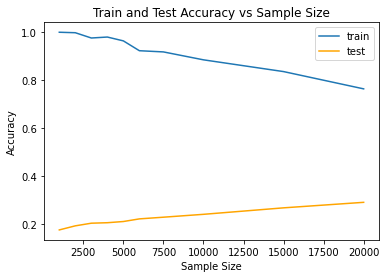

In [5]:
xs = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7500, 10000, 15000, 20000])
ys_tr = np.array([0.176, 0.193, 0.204, 0.206, 0.211, 0.222, 0.229, 0.241, 0.268, 0.291])
ys_te = np.array([1.0, 0.998, 0.976, 0.980, 0.964, 0.923, 0.918, 0.885, 0.836, 0.764])
plt.title("Train and Test Accuracy vs Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.plot(xs, ys_te, c='#1f77b4')
plt.plot(xs, ys_tr, c='orange')
plt.legend(["train", "test"], fontsize=10)

plt.show()

##time vs sample size##

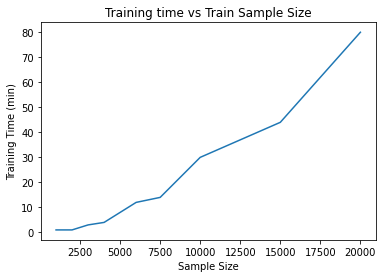

In [ ]:
xs = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7500, 10000, 15000, 20000])
ys = np.array([1, 1, 3, 4, 8, 12, 14, 30, 44, 80])
plt.title("Training time vs Train Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Training Time (min)")
plt.plot(xs, ys)

plt.show()

In [ ]:
xs = np.array([1000, 2000, 3000, 4000, 5000, 6000, 7500, 10000, 15000, 20000])
ys = np.array([1.0, 0.998, 0.976, 0.980, 0.964, 0.923, 0.918, 0.885, 0.836, 0.764])
plt.title("Training time vs Train Sample Size")
plt.xlabel("Sample Size")
plt.ylabel("Training Time (min)")
plt.plot(xs, ys)

plt.show()

#Testing Random Samples#

In [ ]:
### Train ###
Images = []
Labels = []
final_train_images = np.load('train_hog_images.npy')
final_train_labels = np.load('train_hog_labels.npy')

In [ ]:
def train_initialize(trainImages, trainLabels):
  N = len(trainImages)

  for i in range(N):
    hog_feature = trainImages[i]
    label = trainLabels[i]

    Images.append(hog_feature)
    Labels.append(label)

In [ ]:
train_initialize(final_train_images, final_train_labels)

print('Training on train images...')
svm_model = LinearSVC(random_state=42, tol=1e-5)
svm_model.fit(Images[:5000], Labels[:5000])
print('Finish training SVM')

Training on train images...
Finish training SVM


In [ ]:
def predict_image(idx):
  # extract image and label
  image_path = 'data_256_standard' + test_paths[idx]
  image = np.asarray(PIL.Image.open(image_path))
  image = cv2.resize(image, (128, 256))

  # make prediction
  (hog_desc, hog_image) = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', visualize=True)
  label_hat = svm_model.predict(hog_desc.reshape(1, -1))[0]
  label_true = test_labels[idx]

  return (image_path, int(label_true), int(label_hat))
 

In [ ]:
def show_image(path_to_image, width=None, height=None):

    mime_type = None
    path_to_image = path_to_image.lower()

    # More MIME types:
    # https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/MIME_types
    if path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg'):
        mime_type = 'image/jpeg'
    elif path_to_image.endswith('.png'):
        mime_type = 'image/png'
    elif path_to_image.endswith('.gif'):
        mime_type = 'image/gif'
    else:
        raise ValueError('Unknown extension: %s' % (path_to_image))

    img = open(path_to_image, 'rb').read()
    data_url = 'data:image/jpeg;base64,' + b64encode(img).decode()

    width_str = "width='%d'" % (width) if width is not None else ''
    height_str = "height='%d'" % (width) if height is not None else ''

    display(HTML("<img src='%s' %s%s>" % (data_url, width_str, height_str)))

In [ ]:
### load catagory ###
with open('categories_places365.txt') as f:
    lines = f.readlines()
print(lines[0])
D = dict()
for line in lines:
  parts = line.split(' ')
  name, label = parts[0], int(parts[1][:-1])
  D[label] = name



/a/airfield 0



In [ ]:
def examplify(idx):
  (filename1, y1, yhat1) = predict_image(idx)
  
  print('i =', idx)
  show_image(filename1)
  print("filename", filename1)
  print("correct label:", D[y1])
  print("predicted label:", D[yhat1])

i = 1, arch and arcade are easily confounded

i = 3, circular curve recognized as the shape of an amplitheatre

i = 0



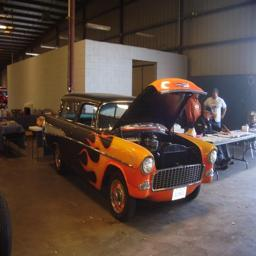

filename data_256_standard/a/assembly_line/00000824.jpg
correct label: /a/assembly_line
predicted label: /a/auto_showroom
i = 1



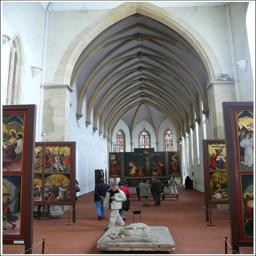

filename data_256_standard/a/arcade/00003021.jpg
correct label: /a/arcade
predicted label: /a/arch
i = 2



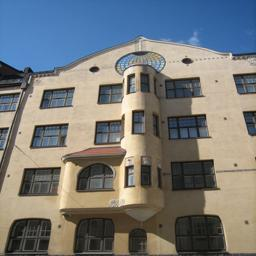

filename data_256_standard/a/apartment_building/outdoor/00001872.jpg
correct label: /a/apartment_building/outdoor
predicted label: /a/amphitheater
i = 3



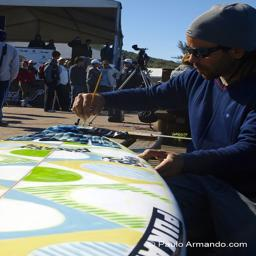

filename data_256_standard/a/art_school/00000981.jpg
correct label: /a/art_school
predicted label: /a/amphitheater
i = 4



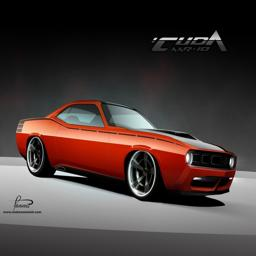

filename data_256_standard/a/auto_showroom/00001222.jpg
correct label: /a/auto_showroom
predicted label: /a/auto_showroom
i = 5



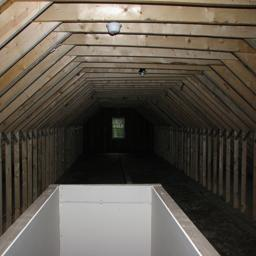

filename data_256_standard/a/attic/00003276.jpg
correct label: /a/attic
predicted label: /a/auto_factory
i = 6



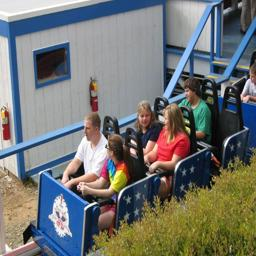

filename data_256_standard/a/amusement_park/00004528.jpg
correct label: /a/amusement_park
predicted label: /a/army_base
i = 7



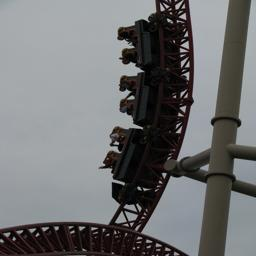

filename data_256_standard/a/amusement_park/00000592.jpg
correct label: /a/amusement_park
predicted label: /a/alcove
i = 8



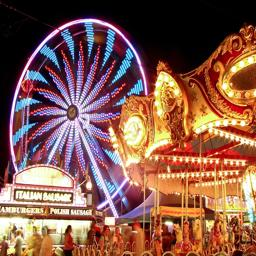

filename data_256_standard/a/amusement_park/00003967.jpg
correct label: /a/amusement_park
predicted label: /a/amusement_park
i = 9



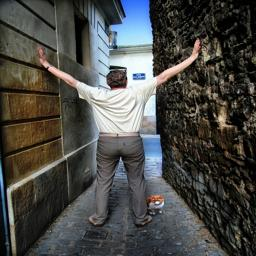

filename data_256_standard/a/alley/00002434.jpg
correct label: /a/alley
predicted label: /a/alley
i = 10



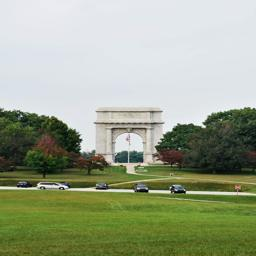

filename data_256_standard/a/arch/00004658.jpg
correct label: /a/arch
predicted label: /a/airfield
i = 11



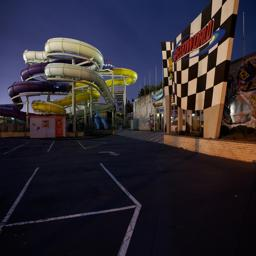

filename data_256_standard/a/amusement_park/00003393.jpg
correct label: /a/amusement_park
predicted label: /a/arena/hockey
i = 12



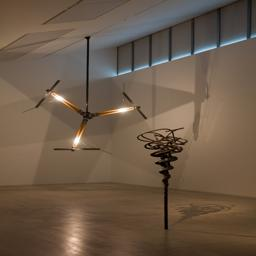

filename data_256_standard/a/art_gallery/00001249.jpg
correct label: /a/art_gallery
predicted label: /a/aquarium
i = 13



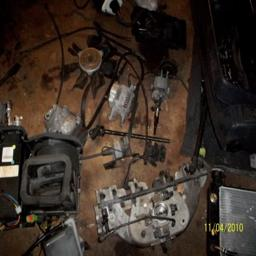

filename data_256_standard/a/attic/00004034.jpg
correct label: /a/attic
predicted label: /a/aqueduct
i = 14



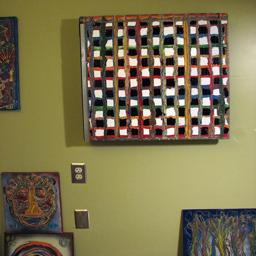

filename data_256_standard/a/art_studio/00002681.jpg
correct label: /a/art_studio
predicted label: /a/amusement_arcade
i = 15



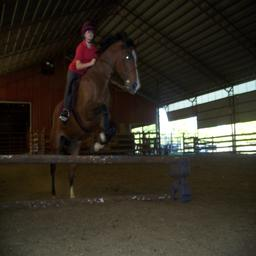

filename data_256_standard/a/arena/rodeo/00002873.jpg
correct label: /a/arena/rodeo
predicted label: /a/airfield
i = 16



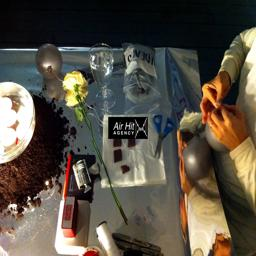

filename data_256_standard/a/art_school/00002529.jpg
correct label: /a/art_school
predicted label: /a/army_base
i = 17



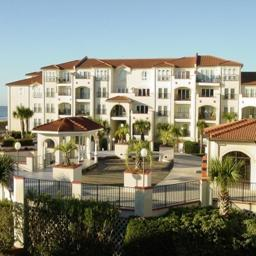

filename data_256_standard/a/apartment_building/outdoor/00000894.jpg
correct label: /a/apartment_building/outdoor
predicted label: /a/aqueduct
i = 18



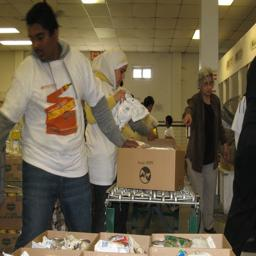

filename data_256_standard/a/assembly_line/00001198.jpg
correct label: /a/assembly_line
predicted label: /a/alcove
i = 19



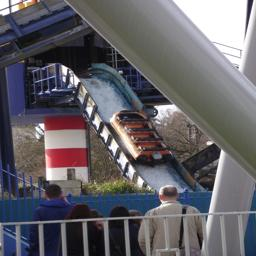

filename data_256_standard/a/amusement_park/00001470.jpg
correct label: /a/amusement_park
predicted label: /a/aquarium


In [ ]:
for i in range(20):
  examplify(i)